# IMPORT

In [600]:
# загружаем необходимые для работы библиотеки
import pandas as pd
import numpy as np
import re 
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [601]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [602]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [603]:
# Открываем необходимые данные, создаем датафреймы
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [604]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [605]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [606]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [607]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [608]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [609]:
sample_submission.head(3)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0


In [610]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [611]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:

* City: Город
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com'
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [612]:
data.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
23987,id_4222,Berlin,NaN,4224.0,NaN,4.0,"[[], []]",/Restaurant_Review-g187323-d2248943-Reviews-Ka...,d2248943,1,4.5
14872,id_9434,Paris,['Japanese'],9436.0,NaN,6.0,"[[], []]",/Restaurant_Review-g187147-d2440502-Reviews-Os...,d2440502,1,4.0
2860,id_2860,Berlin,['Cafe'],5296.0,$,4.0,"[['And life becomes better', 'Super friendly &...",/Restaurant_Review-g187323-d8558215-Reviews-Ca...,d8558215,0,0.0


In [613]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

# Cleaning and Prepping Data

## 1. Обработка NAN 
Из предыдущего шага в info можно было увидеть, что есть отсутствующие значения по 4 признакам. Добавим информацию о NAN по каждому признаку в отдельные столбцы

In [614]:
data['Cuisine Style isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')
data['Cuisine Style isNAN'].sum()

11590

In [615]:
data['Price Range isNAN'] = pd.isna(data['Price Range']).astype('uint8')
data['Price Range isNAN'].sum()

17361

In [616]:
data['Number of Reviews isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
data['Number of Reviews isNAN'].sum()

3200

In [617]:
data['Reviews isNAN'] = pd.isna(data['Reviews']).astype('uint8')
data['Reviews isNAN'].sum()

2

В столбцах Price Range и Cuisine Style большое количество пропусков. По условию задания эти значения попробуем заменить.

Признак Cuisine Style

В этом столбце большое количество пропусков. Поскольку это категориальный признак и у нас нет дополнительной информации, для удобства заменим NaN на значение 'Unknown'.

In [618]:
data['Cuisine Style'] = data['Cuisine Style'].fillna('unknown')

Признак Price Range

Посмотрим на распределение признака.

In [619]:
data['Price Range'].value_counts(normalize=True)

$$ - $$$    0.705935
$           0.239468
$$$$        0.054597
Name: Price Range, dtype: float64

Видим, что порядка 70% заведений находятся в средней ценовой категории. Это позволяет заменить пропуски модой

In [620]:
data['Price Range'].fillna(data['Price Range'].mode()[0], inplace = True)

Признак Number of Reviews

Посмотрим описание данных

In [621]:
data['Number of Reviews'].describe()

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

Сильное отличие среднего значения и медианы говорит о наличии выбросов.
Наиболее удобным способом заполнения будет замена пропусков нулями.

In [622]:
data['Number of Reviews'].fillna(0, inplace=True)

In [623]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Restaurant_id            50000 non-null  object 
 1   City                     50000 non-null  object 
 2   Cuisine Style            50000 non-null  object 
 3   Ranking                  50000 non-null  float64
 4   Price Range              50000 non-null  object 
 5   Number of Reviews        50000 non-null  float64
 6   Reviews                  49998 non-null  object 
 7   URL_TA                   50000 non-null  object 
 8   ID_TA                    50000 non-null  object 
 9   sample                   50000 non-null  int64  
 10  Rating                   50000 non-null  float64
 11  Cuisine Style isNAN      50000 non-null  uint8  
 12  Price Range isNAN        50000 non-null  uint8  
 13  Number of Reviews isNAN  50000 non-null  uint8  
 14  Reviews isNAN         

Признак Reviews

In [624]:
# Посмотрим, что содержится в столбце с ревью.
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Пропусков очень мало, но структура данных долвольно сложная. Заполним пропуски на следующих этапах

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [625]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    3
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Cuisine Style isNAN            2
Price Range isNAN              2
Number of Reviews isNAN        2
Reviews isNAN                  2
dtype: int64

Предварительно категориальными являются признаки:
* City
* Cuisine Style
* Price Range

#### Restaurant_id

In [626]:
data.Restaurant_id.value_counts()

id_436      19
id_633      19
id_871      19
id_227      19
id_534      18
            ..
id_16361     1
id_12743     1
id_12994     1
id_12166     1
id_8540      1
Name: Restaurant_id, Length: 13094, dtype: int64

По количеству повторяющихся значений видно, что id ресторанов не является уникальным значением. Это может означать, что часть ресторанов представлена как самостоятельные, а другая часть - как группа заведений под одним брендом

In [627]:
# переведем столбец Restaurant_id в числовой формат с помощью преобразования
data.Restaurant_id = data.Restaurant_id.apply(lambda x: int(x[3:]))

In [628]:
data.Restaurant_id.sample(5)

25668    2659
36215     175
1146     1146
25879     654
27132    1918
Name: Restaurant_id, dtype: int64

In [629]:
# количество уникальных ID
data.Restaurant_id.nunique()

13094

Создадим новый признак "rest_group", который будет принимать значение 0, если ресторан несетевой и 1, если ресторан сетевой.

In [630]:
rest_group_id = data['Restaurant_id'].value_counts().loc[lambda x: x>1].index # найдем ID ресторана

In [631]:
data['rest_group'] = data['Restaurant_id'].apply(lambda x: 1 if x in rest_group_id else 0)

In [632]:
data['rest_group'].value_counts()

1    46193
0     3807
Name: rest_group, dtype: int64

#### City

In [633]:
# Посмотрим на количество уникальных городов
data.City.nunique()

31

В выборке 31 город, что не очень много. Можно применить dummy-кодирование.

In [634]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [635]:
data.sample(3)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
791,791,unknown,353.0,$$ - $$$,2.0,"[['Cool name for the bar'], ['01/01/2015']]",/Restaurant_Review-g274924-d4769839-Reviews-Co...,d4769839,0,0.0,...,0,0,0,0,0,0,0,0,0,0
500,500,['Italian'],7044.0,$$ - $$$,13.0,"[['Such a wonderful experience', 'Smettila di ...",/Restaurant_Review-g187514-d5111086-Reviews-Ac...,d5111086,0,0.0,...,0,0,0,0,0,0,0,0,0,0
16925,2576,"['International', 'European', 'Grill']",2594.0,$$ - $$$,35.0,"[['Meh, but good location for coffee and a si....",/Restaurant_Review-g187309-d811967-Reviews-New...,d811967,1,3.0,...,0,0,0,0,0,0,0,0,0,0


#### Cuisine Style

In [636]:
# Пример данных
data['Cuisine Style'].sample(3)

41036    ['British', 'Vegetarian Friendly']
33479                               unknown
7500                                unknown
Name: Cuisine Style, dtype: object

In [637]:
# Для начала создадим функцию для преобразования строки в список
def clean_name(str_val):
    str_val = str_val.strip("[]") # Отбрасываем скобки.
    str_val = str_val.replace("\'",'') # Убираем кавычки '.
    str_val = str_val.split(", ") # Разбиваем строку по названиям кухонь.
    return str_val

In [638]:
data['Cuisine Style'] = data['Cuisine Style'].apply(clean_name) 

In [639]:
# можно оценить среднее количество кухонь в ресторане
summa = 0
for i in range(len(data['Cuisine Style'])):
    summa += len (data['Cuisine Style'][i])
summa / len (data['Cuisine Style'])

2.62532

In [640]:
# посмотрим распределение уникальных кухонь.
Cuisines = set() 
for i in data['Cuisine Style']:
    for j in i:
        Cuisines.add(j)

len(Cuisines)-1    # не забываем отбросить unknown

125

Добавим новый признак - количество кухонь, представленных в ресторане

In [641]:
col = []
for i in range(len(data['Cuisine Style'])):
    col.append(len(data['Cuisine Style'][i]))
    
data['Cuisine Style number'] = col

In [642]:
data.head(3)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Cuisine Style number
0,0,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,1,0,0,0,0,0,0,0,2
1,1,"[European, Scandinavian, Gluten Free Options, ...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,5
2,2,[Vegetarian Friendly],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [643]:
# наиболее часто встречающееся значение кухни
data.explode('Cuisine Style')['Cuisine Style'].value_counts()

Vegetarian Friendly    14021
European               12561
unknown                11590
Mediterranean           7820
Italian                 7433
                       ...  
Yunnan                     2
Salvadoran                 1
Burmese                    1
Xinjiang                   1
Latvian                    1
Name: Cuisine Style, Length: 126, dtype: int64

#### Price Range

Значения этого столбца можно ранжировать, заменив категории цен на числа по возрастанию. Таким образом, признак Price Range можно сделать из категориального последовательным.

In [644]:
data['Price Range'] = data['Price Range'].replace('$','1')
data['Price Range'] = data['Price Range'].replace('$$ - $$$','2')
data['Price Range'] = data['Price Range'].replace('$$$$','3')

data['Price Range'] = data['Price Range'].apply(lambda x: int(x)) # преобразуем колонку в числовой формат

#### Reviews

In [645]:
# Вспомним, как выглядит столбец ревью.
data.Reviews[9]

"[['Good food', 'Good pizza'], ['12/02/2017', '10/29/2017']]"

In [646]:
# В тестовой выборке есть пустые значения, заменим их на строку, которая показывает, что ревью нет.
data['Reviews'].fillna('[[], []]', inplace=True)

In [647]:
# Выделим из отзыва даты и на основе этого создадим новый признак review_date
pattern = re.compile('\d+\/\d+\/\d+')
data['review_date'] = data.Reviews.apply(pattern.findall)

data['review_date'].head(5)

0                          []
1    [12/05/2017, 10/29/2017]
2    [12/28/2017, 12/06/2017]
3    [12/06/2017, 11/22/2017]
4    [02/08/2018, 01/24/2018]
Name: review_date, dtype: object

In [648]:
# переводим в формат datetime64
data['review_date'] = pd.to_datetime(data.review_date.apply(lambda x: x[0] if len(x) >=1 else None))

In [649]:
data.review_date.value_counts()

2018-01-07    607
2018-01-03    534
2018-01-06    498
2018-01-04    461
2018-01-08    460
             ... 
2014-03-20      1
2015-03-27      1
2011-10-01      1
2013-07-29      1
2014-07-12      1
Name: review_date, Length: 1976, dtype: int64

In [650]:
# Заполним пропуски модой, так как есть часто встречающиеся даты
data['review_date'].fillna(data['review_date'].mode()[0], inplace = True)

In [651]:
# для построения модели этот признак может быть полезен. Однако нам нужен числовой формат.
# Для удобства можно конвертировать данные этого столбца из формата datetime64 в формат unix time и вынести в отдельный признак
unix_time = []
for i in range(len(data['review_date'])):
    unix_time.append(data['review_date'][i].timestamp())

data['unix_review_date'] = unix_time

In [652]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Restaurant_id            50000 non-null  int64         
 1   Cuisine Style            50000 non-null  object        
 2   Ranking                  50000 non-null  float64       
 3   Price Range              50000 non-null  int64         
 4   Number of Reviews        50000 non-null  float64       
 5   Reviews                  50000 non-null  object        
 6   URL_TA                   50000 non-null  object        
 7   ID_TA                    50000 non-null  object        
 8   sample                   50000 non-null  int64         
 9   Rating                   50000 non-null  float64       
 10  Cuisine Style isNAN      50000 non-null  uint8         
 11  Price Range isNAN        50000 non-null  uint8         
 12  Number of Reviews isNAN  50000 n

Сейчас мы видим, что пропущенных значений не осталось и сформированы новые признаки

# EDA

### Посмотрим распределение признака

<AxesSubplot:>

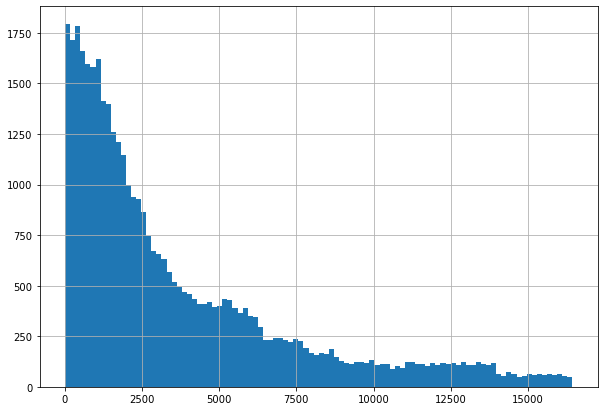

In [653]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

<AxesSubplot:>

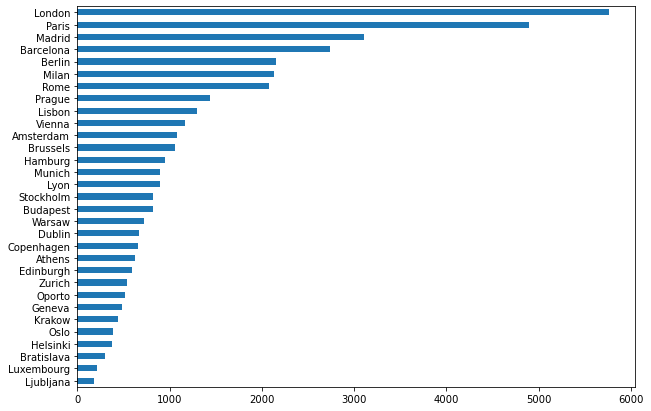

In [654]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

<AxesSubplot:>

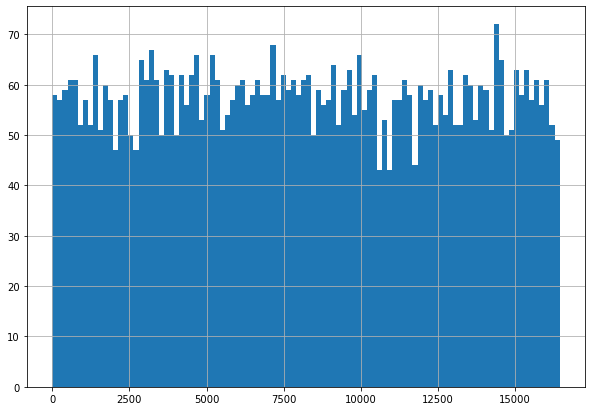

In [655]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

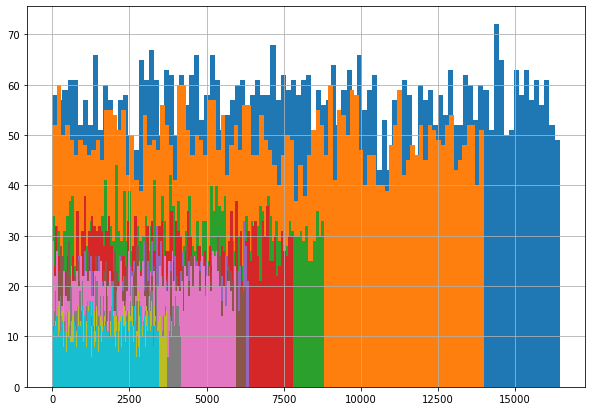

In [656]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

<AxesSubplot:>

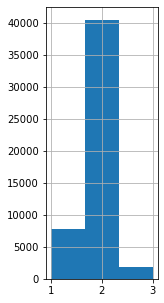

In [657]:
# распределение ресторанов по ценовым категориям
plt.rcParams['figure.figsize'] = (2,5)
data['Price Range'].hist(bins=3)

Наибольшее количество ресторанов - в средней ценовой категории

### Посмотрим распределение целевой переменной

<AxesSubplot:>

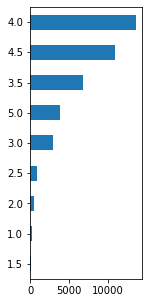

In [658]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

<AxesSubplot:>

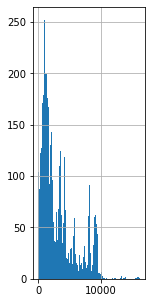

In [659]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

<AxesSubplot:>

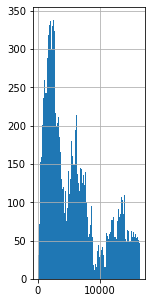

In [660]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### Корреляция признаков
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

<AxesSubplot:>

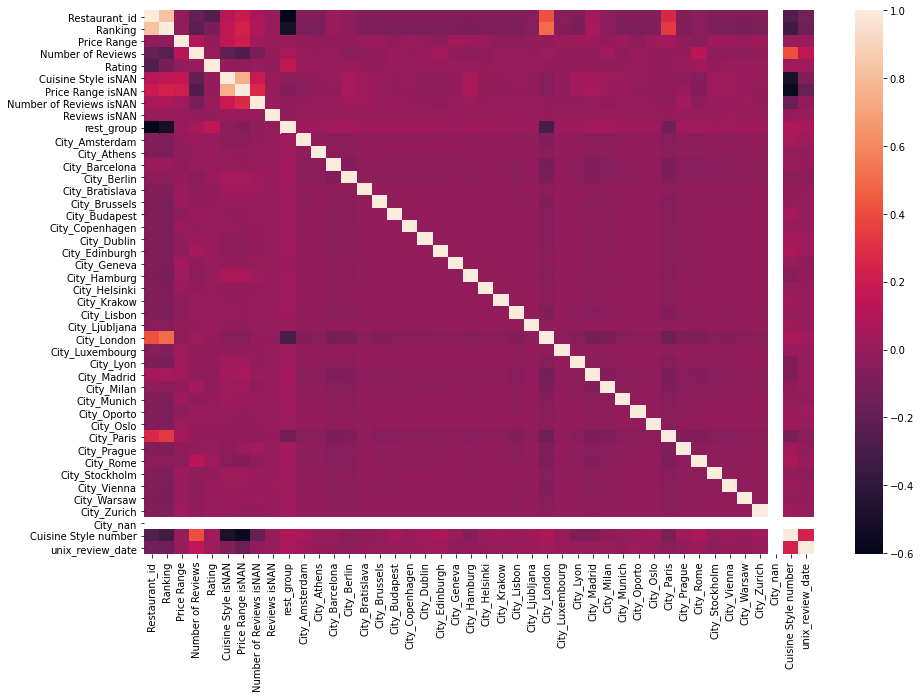

In [661]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [662]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [663]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Cuisine Style'] = df_output['Cuisine Style'].fillna('unknown')
    df_output['Price Range'].fillna(data['Price Range'].mode()[0], inplace = True)
    df_output['Number of Reviews'].fillna(0, inplace=True)
    df_output['Reviews'].fillna('[[], []]', inplace=True)
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    
    
    # ################### 4. Feature Engineering ####################################################
    # переведем столбец Restaurant_id в числовой формат с помощью преобразования
    df_output.Restaurant_id = df_output.Restaurant_id.apply(lambda x: int(x[3:]))
    rest_group_id = df_output['Restaurant_id'].value_counts().loc[lambda x: x>1].index # найдем ID ресторана
    df_output['rest_group'] = df_output['Restaurant_id'].apply(lambda x: 1 if x in rest_group_id else 0)
    
    # Признак CUISINE STYLE
    # функция, преобразующая строку с названиями кухонь в понятный компьютеру список [list] названий кухонь
    def clean_name(str_val):
        str_val = str_val.strip("[]") # Отбрасываем скобки.
        str_val = str_val.replace("\'",'') # Убираем кавычки '.
        str_val = str_val.split(", ") # Разбиваем строку по названиям кухонь.
        return str_val
    # применяем функцию преобразования содержимого колонки Cuisine_Style в список
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(clean_name) 
    col = []
    for i in range(len(df_output['Cuisine Style'])):
        col.append(len(df_output['Cuisine Style'][i]))
    df_output['Cuisine Style number'] = col

    # Признак PRICE RANGE
    df_output['Price Range'] = df_output['Price Range'].replace('$','1')
    df_output['Price Range'] = df_output['Price Range'].replace('$$ - $$$','2')
    df_output['Price Range'] = df_output['Price Range'].replace('$$$$','3')
    df_output['Price Range'] = df_output['Price Range'].apply(lambda x: int(x)) # преобразуем колонку в числовой формат

    # Признак REVIEWS
    # Создадим новый признак review_date на основе патерна поиска дат.
    pattern = re.compile('\d+\/\d+\/\d+')
    df_output['review_date'] = df_output.Reviews.apply(pattern.findall)
    # Переводим в формат datetime64
    df_output['review_date'] = pd.to_datetime(df_output.review_date.apply(lambda x: x[0] if len(x) >=1 else None))
    df_output['review_date'].fillna(df_output['review_date'].mode()[0], inplace = True)

    # переводим данные в числовой формат (unix time)
    unix_time = []
    for i in range(len(df_output['review_date'])):
        unix_time.append(df_output['review_date'][i].timestamp())
    df_output['unix_review_date'] = unix_time

    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)

    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes in ['object', '<M8[ns]']]
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [664]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Price Range,Number of Reviews,sample,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,...,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,rest_group,Cuisine Style number,unix_review_date
22589,2305.0,2,82.0,1,3.5,0,0,0,0,0,...,0,0,0,1,0,0,0,1,3,1.480810e+09
18665,1497.0,2,40.0,1,3.5,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1.501373e+09
3886,6342.0,1,23.0,0,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,2,1.471046e+09
10476,1244.0,2,12.0,1,4.5,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,1.405123e+09
39244,8527.0,2,44.0,1,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2,1.474070e+09
26409,6982.0,2,7.0,1,4.5,0,0,0,0,0,...,0,0,0,0,0,0,0,1,5,1.507766e+09
35500,3545.0,2,631.0,1,3.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2,1.506125e+09
37250,2669.0,2,0.0,1,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1.515283e+09
41908,3421.0,2,107.0,1,4.0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,5,1.443917e+09
48034,279.0,2,147.0,1,4.5,0,0,0,0,0,...,0,0,0,0,0,0,0,1,5,1.515283e+09


In [665]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Ranking               50000 non-null  float64
 1   Price Range           50000 non-null  int64  
 2   Number of Reviews     50000 non-null  float64
 3   sample                50000 non-null  int64  
 4   Rating                50000 non-null  float64
 5   City_Amsterdam        50000 non-null  uint8  
 6   City_Athens           50000 non-null  uint8  
 7   City_Barcelona        50000 non-null  uint8  
 8   City_Berlin           50000 non-null  uint8  
 9   City_Bratislava       50000 non-null  uint8  
 10  City_Brussels         50000 non-null  uint8  
 11  City_Budapest         50000 non-null  uint8  
 12  City_Copenhagen       50000 non-null  uint8  
 13  City_Dublin           50000 non-null  uint8  
 14  City_Edinburgh        50000 non-null  uint8  
 15  City_Geneva        

In [666]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [667]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [668]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 39), (40000, 39), (40000, 38), (32000, 38), (8000, 38))

# Model 
Сам ML

In [669]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [670]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [671]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [672]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20822312499999998


<AxesSubplot:>

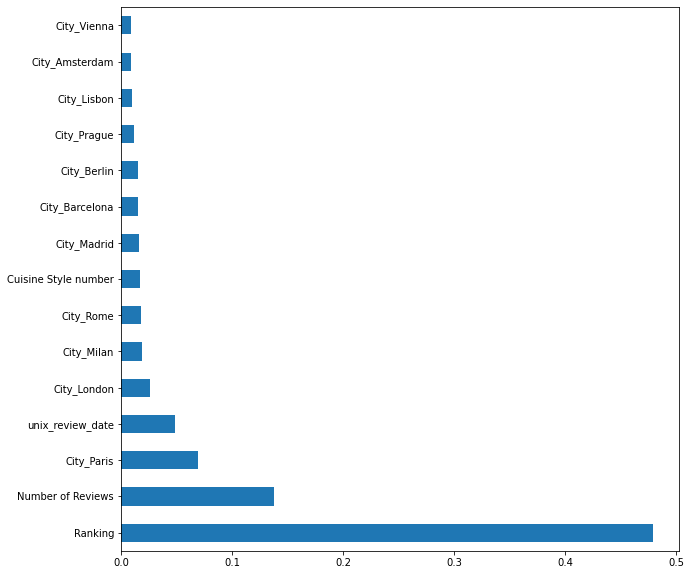

In [673]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [674]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,...,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,rest_group,Cuisine Style number,unix_review_date
3738,642.0,2,27.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.480118e+09
2442,4313.0,2,22.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1.515283e+09
9906,1139.0,2,5.0,0.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,1.447805e+09
9735,2445.0,2,115.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,6,1.508112e+09
1188,2243.0,3,106.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1.515283e+09
3129,7889.0,2,15.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1.450915e+09
9301,4063.0,2,0.0,0.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1.445990e+09
3016,2831.0,2,73.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,4,1.444954e+09
3398,3456.0,2,161.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,5,1.504656e+09
9280,7770.0,2,7.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,5,1.515283e+09


In [675]:
test_data = test_data.drop(['Rating'], axis=1)

In [676]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [677]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [678]:
predict_submission

array([3.02 , 4.165, 4.465, ..., 3.005, 4.495, 4.46 ])

In [679]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.020
1,id_1,4.165
2,id_2,4.465
3,id_3,4.285
4,id_4,4.450
5,id_5,4.435
6,id_6,1.840
7,id_7,2.955
8,id_8,4.080
9,id_9,4.645


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

# CONCLUSION

1. Были добавлены новые признаки: 
* Наличие пропусков в изначальных данных по признакам City, Cuisine Style, Price Range, Number of Reviews. 
* Cuisine Style number - количество типов кухонь ресторана
* review_date - даты отзывов
* unix_review_date - даты отзывов в unix формате
* rest_group - категория ресторана (сетевой или нет)
* Созданы столбцы с фиктивными переменными для признака City (31 столбец)

После отбора признаков для модели был получен результат:
MAE:  0.2082